In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time

from datetime import datetime

from xfoil import XFoil
from xfoil.model import Airfoil

from lib.utils import load_pkl, save_pkl
from lib.preprocess_modules import *
from lib.predict_modules import *
from config import *

from nets.nn import *

In [2]:
model = light_param_net(3072)
model.load_weights(str(Path('./weights', 'train v4 bs12 2020-12-31 11-47.h5')))

Light parametrization net output shape: (None, 512, 512, 1)


In [3]:
fname = "e387 desired.xls" 

In [4]:
df = pd.read_excel(Path(os.getcwd(),fname))
df

,Param,Re,S,d,-2.1,-1.78,-1.47,-1.15,-0.84,-0.52,...,4.84,5.16,5.48,5.79,6.11,6.42,6.74,7.05,7.37,7.68
0,Cy,40000,0.08,0.05,-0.175271,-0.149215,-0.122368,-0.096956,-0.070861,-0.044806,...,0.494016,0.522079,0.547024,0.570193,0.614365,0.630143,0.666479,0.702953,0.737705,0.749133
1,Cy,50666,0.08,0.05,-0.126504,-0.073382,-0.033211,0.008268,0.055054,0.089171,...,0.603522,0.630642,0.657340,0.687416,0.730997,0.755593,0.782671,0.837690,0.974164,0.962597
2,Cy,61333,0.08,0.05,-0.016765,0.034532,0.067431,0.107558,0.152161,0.183288,...,0.707919,0.755507,0.806188,0.844763,0.990552,1.012872,1.004646,0.981187,0.976996,0.972574
3,Cy,72000,0.08,0.05,0.111640,0.181871,0.244588,0.330845,0.381140,0.463936,...,1.333391,1.389392,1.481975,1.603389,1.653134,1.667295,1.611005,1.623479,1.635125,1.637587
4,Cy,82666,0.08,0.05,0.250990,0.317135,0.382396,0.463928,0.520372,0.588009,...,1.552398,1.627355,1.714465,1.765231,1.801868,1.797575,1.770482,1.789920,1.801065,1.801897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Cp,157333,0.08,0.05,-1.095203,-0.961417,-0.883718,-0.797703,-0.708582,-0.616246,...,-1.432442,-1.658471,-1.967260,-2.151952,-2.229256,-2.400024,-2.578504,-2.752281,-2.895835,-2.987009
60,Cp,168000,0.08,0.05,-1.049246,-0.969676,-0.889326,-0.803220,-0.712517,-0.619784,...,-1.431457,-1.665568,-1.971450,-2.132275,-2.227237,-2.398644,-2.576588,-2.749870,-2.906410,-2.998260
61,Cp,178666,0.08,0.05,-1.044247,-0.975340,-0.894305,-0.807379,-0.716861,-0.623241,...,-1.431969,-1.672259,-1.973815,-2.114706,-2.225747,-2.402810,-2.576052,-2.743838,-2.913803,-3.004927
62,Cp,189333,0.08,0.05,-1.051441,-0.979565,-0.898479,-0.811864,-0.720704,-0.627215,...,-1.431100,-1.677790,-1.974426,-2.099223,-2.224575,-2.416185,-2.516938,-2.736221,-2.919902,-3.006381


In [5]:
Re = df.Re.unique().tolist()
alfas = df.columns[4:].tolist()
S = df.iloc[0,2]
d = df.iloc[0,3]
print('What in "%s"?\n' % fname)
print("Available Re's:", Re)
print("Available alfas:", alfas)
print("Required S:", S)
print("Required d:", d)

What in "e387 desired.xls"?

Available Re's: [40000, 50666, 61333, 72000, 82666, 93333, 104000, 114666, 125333, 136000, 146666, 157333, 168000, 178666, 189333, 200000]
Available alfas: [-2.1, -1.78, -1.47, -1.15, -0.84, -0.52, -0.21, 0.11, 0.43, 0.74, 1.06, 1.37, 1.69, 2, 2.32, 2.63, 2.95, 3.27, 3.58, 3.9, 4.21, 4.53, 4.84, 5.16, 5.48, 5.79, 6.11, 6.42, 6.74, 7.05, 7.37, 7.68]
Required S: 0.08
Required d: 0.05


In [6]:
foil_array = np.zeros((n_foil_params, n_points_Re, n_points_alfa), dtype='float64')
foil_array[0,:,:] = df.iloc[0:16,4:]
foil_array[1,:,:] = df.iloc[16:32,4:]
foil_array[2,:,:] = df.iloc[32:48,4:]
foil_array[3,:,:] = df.iloc[48:64,4:]
foil_array[4,:,:] = d
foil_array[5,:,:] = S
foil_array[6,:,:] = (np.array((Re))*np.ones((32,16))).T
foil_array[7,:,:] = (np.array((alfas))*np.ones((16,32)))

In [7]:
foil_array = foil_array[:6,...]
foil_array.shape

(6, 16, 32)

In [8]:
X = foil_array.reshape(foil_array.shape[0]*foil_array.shape[1]*foil_array.shape[2])
re_dict = dict(zip(Re, range(len(Re))))

In [9]:
X.shape

(3072,)

In [10]:
y = np.round(model.predict(X[None,:]))[0, :, :, 0]
y.shape

(512, 512)

In [12]:
fname

'e387 desired.xls'

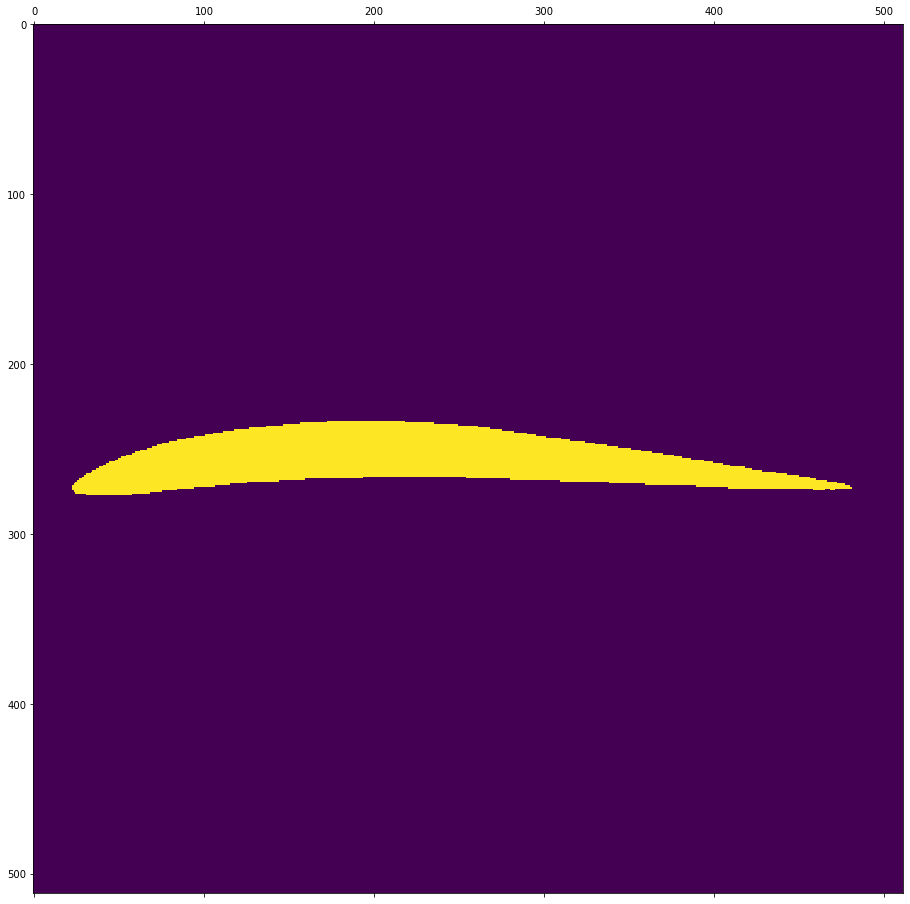

In [14]:
plt.figure(figsize=(16,16))
plt.matshow(y,0)
plt.savefig(Path(os.getcwd(),fname.replace(' desired.xls', '.png')))

In [12]:
# ищем координаты

# сначала определим координаты начала и конца оси профиля

for x_nose in range(y.shape[1]):
    res = find_first_and_last_1_position(y[:, x_nose])
    if res!=-1:
        y_nose_top, y_nose_bot = res
        break
        
for x_tail in range(y.shape[1]-1,0,-1):
    res = find_first_and_last_1_position(y[:, x_tail])
    if res!=-1:
        y_tail_top, y_tail_bot = res
        break

if y_nose_top!=y_nose_bot: # ставим точку в середине носика, пригодится для красивой аппроксимации
    y_nose = int(np.average((y_nose_top, y_nose_bot)))
    y[y_nose,x_nose-1]=1
    x_nose-=1

if y_tail_top!=y_tail_bot: # а на хвостике не ставим 
    pass

y=y[:, x_nose:x_tail+1]

foil_x_top = (np.arange(y.shape[1])).tolist(); foil_x_top.reverse()
foil_x_bot = foil_x_top.copy() 
foil_y_top=[]
foil_y_bot=[]

# ищем верхнюю и нижнюю границы профиля
for x in foil_x_top:
    if find_first_and_last_1_position(y[:, x])!=-1:
        y_t, y_b = find_first_and_last_1_position(y[:, x])
        foil_y_top.append(y_nose - y_t)
        foil_y_bot.append(y_nose - y_b)
    else:
        foil_y_top.append(None)
        foil_y_bot.append(None)

# склеиваем верх и низ
foil_x_bot = foil_x_bot[:-1]
foil_x_bot.reverse()
foil_y_bot = foil_y_bot[:-1]
foil_y_bot.reverse()
foil_x_top.extend(foil_x_bot)
foil_y_top.extend(foil_y_bot)

foil_x_top = np.array(foil_x_top)
foil_y_top = np.array(foil_y_top)
        
foil_x = []
foil_y = []

# удаляем точки, где дыры в У
for i in range(foil_x_top.shape[0]):
    if foil_y_top[i]!=None:
        foil_x.append(foil_x_top[i])
        foil_y.append(foil_y_top[i])

# нормируем к 1
foil_x = np.array(foil_x)/(y.shape[1]-1)
foil_y = np.array(foil_y)/(y.shape[1]-1)
foil_x.shape, foil_y.shape

((921,), (921,))

In [13]:
src_x, src_y = read_airfoil_dat_file(Path(foils_dat_path, 'e387.dat'))

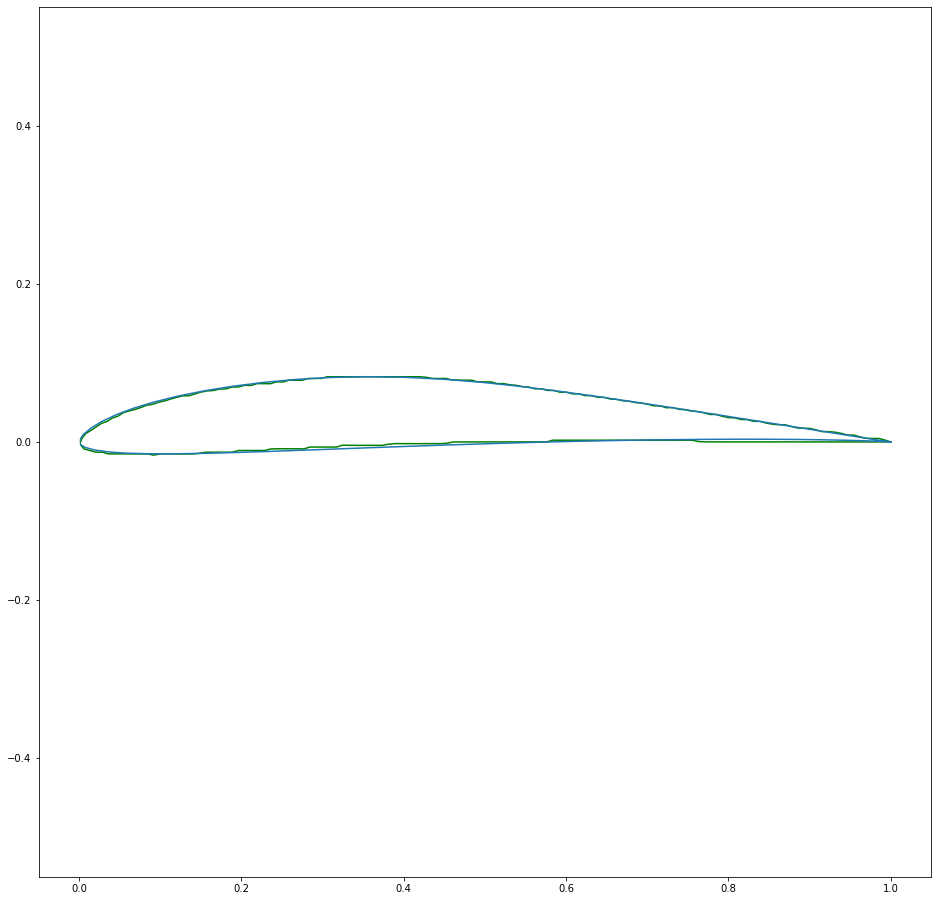

In [16]:
f_x, f_y = interpolate_airfoil(foil_x, foil_y, n_points_in_predicted_dat)
plt.figure(figsize=(16,16))
plt.plot(f_x, f_y, 'green'), plt.plot(src_x, src_y), plt.plot([0,0],[-0.5,0.5],'white');

In [30]:
df = pd.DataFrame(np.array((f_x, f_y)).T, columns=[fname.replace('desired.xls', 'predicted at'), str(datetime.now())[:19]],dtype='float32')
savename = fname.replace('desired.xls', 'predicted.dat')
df.to_csv(Path(os.getcwd(),savename), index=None, sep=' ')

In [31]:
# get alfa step
alfa_step, _ = get_alfa_step(alfa_min, alfa_max, n_points_alfa)

print("Alfas:", alfas)
print("Re's:", Re)
                   
print('Generate new foil data array...')        
foil_array = create_foil_array_from_dat_file(Path(os.getcwd(), savename), Re, alfas, alfa_min, alfa_max, alfa_step)        

save_pkl(foil_array, Path(foils_pkl_path, savename.replace('.dat', '.pkl')))
print('Foil data array saved as %s ' % Path(foils_pkl_path, savename.replace('.dat', '.pkl')))              

assert isinstance(foil_array, dict), 'Foil array is not a dict.'

foil_array = foil_array['X']
S = foil_array[5,0,0]
d = foil_array[4,0,0]

db = np.zeros((4*len(Re), 4+len(alfas)))
idx=['Param', 'Re', 'S', 'd']
for i in range(len(alfas)): idx.append(str(round(alfas[i],2)))
db = pd.DataFrame(db, columns=idx)

abs_idx=0

params = dict(zip(range(4),['Cy', 'Cx', 'Cm', 'Cp']))

for param in params.keys():
    layer = param
    for re_num, re in enumerate(Re):
        db.iloc[abs_idx, 0]=params[param]
        db.iloc[abs_idx, 1]=re
        db.iloc[abs_idx, 2]=S
        db.iloc[abs_idx, 3]=d
        db.iloc[abs_idx, 4:]=foil_array[layer, re_num, :]            
        abs_idx+=1
try:
    print('Saving as', savename.replace('.dat', '.xlsx'))
    db.to_excel(savename.replace('.dat', '.xlsx'), sheet_name='predicted', index=False)
except:
    print('\n\nFile',savename.replace('.dat', '.xlsx'),'was not saved, because it opened by user.')

print('\n\nReady, file saved as:', savename.replace('.dat', '.xlsx'))

time.sleep(2)

Alfas: [-2.1, -1.78, -1.47, -1.15, -0.84, -0.52, -0.21, 0.11, 0.43, 0.74, 1.06, 1.37, 1.69, 2, 2.32, 2.63, 2.95, 3.27, 3.58, 3.9, 4.21, 4.53, 4.84, 5.16, 5.48, 5.79, 6.11, 6.42, 6.74, 7.05, 7.37, 7.68]
Re's: [40000, 50666, 61333, 72000, 82666, 93333, 104000, 114666, 125333, 136000, 146666, 157333, 168000, 178666, 189333, 200000]
Generate new foil data array...
     --> 256 NaNs corrected.
Foil data array saved as Foils DB\pkl\e387 predicted.pkl 
Saving as e387 predicted.xlsx


Ready, file saved as: e387 predicted.xlsx


NameError: name 'time' is not defined